# Group
  Belal Aboabdo A1234598
  
  Kevin Gong A11334214
  
  Andrew Hwang A12060931
  
  Momin Khan A11625774
  
  Ranvijay Singh A10814334
  
  Guanliang Yan A12267638

# Introduction
  Are diseases distributed differently across different cities within San Diego County and are their frequencies dependent on socioeconomic backgrounds?
  
  We know that research have shown that socioeconomic backgrounds have tremendous impacts on education level, crime rates, voting turnouts, and access to social welfare. For our project, we want to see specifically within San Diego County how common diseases are also affected by income.
  
  Our hypothesis was that there is no correlation between socioeconomic statuses and the frequency of diseases across San Diego County. We limited our observations to the top 3-5 most commonly occuring diseases in each respective zip code in San Diego County.
  
# Background
  Disease is an issue that has affected all of us personally and/or people close to us. One of the biggest weaknesses of the current disease diagnostic system is the insufficient emphasis placed on disease prevention. Often times, many diseases are initially treatable but are left undiagnosed and untreated until it is too late. In an increasingly data-driven society, we aim to utilize the skills we have learned in this class towards the ultimate goal of improving the detection and treatment of the most prevalent diseases that afflict our present day world. If we could prove that correlations exist between socioeconomic statuses and the frequency of certain diseases, we can allow healthcare professionals to focus more effort and energy on detecting and treating certain diseases in areas with correlated socioeconomic statuses.
  
  Similar studies have been done in the past to understand the relationship between certain diseases and its treatment in poverty-stricken areas. A study in 2015 examined Cutaneous Leishmaniasis —— a notable poverty-associated disease —— and how it was treated among patients of different socioeconoimc statuses. Patients at a dermatology clinic at Imam Reza Hospital were classified as low, medium, or high socioeconomic status and provided treatment for the disease over the course of the following year. The study concluded that poverty did seem to prolong the course of the disease.
  
  Another study in 2014 explored the relationship between cardiovascular diseases and socioeconomic status in a retirement community in Shanghai. Other factors such as education level, marital status, annual income, etc. were taken into account. Using a logistical regressional model, the study looked to see if socioeconomic status correlated to increased chances of cardiovascular issues at all. The study concluded that there was no direct correlation between the two. Furthermore, different socioeconomic groups received different intervention plans because each group exhibited different risks.


# Data Description
   The data used in this notebook were taken from government websites such as the IRS website. 
    
   The first set of data is from the CDC's 500 cities: local data for better health dataset which includes data from 2013 and 2014. The set of data include measures such as population, Geolocation, city name. Dieseases are split inot  3 sub-categories of health related data including unhealthy behaviors, prevention, and health outcomes. The Data value for each disease is calculated by dividing the number of respondents aged ≥18 years who report having been told by a doctor, nurse, or other health professional that they had a given disease by respondents aged ≥18 years who answered “yes” or “no” to the following question: “Have you ever been told by a doctor, nurse, or other health professional that you have some form of X disease?” (excluding those who refused to answer, had a missing answer, or answered “don’t know/not sure”). 
    
   The second set of data is from a set of SOI (Statistics of data) tax return statistics from the years 1998, 2001 and 2004 through 2014. We will be using the one from 2014 to match the health data. The data include categories such as number of households, wages and salaries, interest received, adjusted gross income etc. We're really interested in the household income here which we will use to test for relations.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import geocoder
import time
from scipy.stats import ttest_ind
from scipy.stats import norm
import statsmodels.api as sm
import patsy

# Data Scrubbing
   We cleaned our original data set removing all data points outside of California then we limited the data to only include data within the perimeter of San Deigo County based off Geolocation. Lastly we used Google Map's geocoder API to request the zipcode of each Geolocation


In [3]:
df = pd.read_csv('SD_County_Data.csv',encoding = 'latin-1')

In [ ]:
#Did this locally because Original Data set was over 25mb
df = df[df['StateAbbr'] == 'CA']
df.to_csv('CA_Cities_Data.csv')

In [ ]:
#Did this locally because Original Data set was over 25mb and took too long to run
#Bbox Border of LongLat for San Diego County
northEast = 33.5050302, -116.0809399
southWest = 32.5342855, -117.5959108

#Convert Geolocation string to tuple to be used by Geocoder
array = []
for location in df['GeoLocation']:
    lat,long1 = location[1:len(location)-1].split(",")
    latLONG = (float(lat),float(long1))
    array.append(latLONG)
df['GeoLocation'] = array
#Limit data to all data within San Diego County
df2 = df[(df['GeoLocation'] >= southWest) & (df['GeoLocation'] <= northEast)]
df2.to_csv('San_Diego_Cities_Data.csv')

In [ ]:
#Did this locally because Original Data set was over 25mb and took too long to run
#Use Google Maps Geocoder API to match to reverse the Geolocation and return its Zipcode
array = []
for latLong in df2['GeoLocation']:
    g = geocoder.google(latLong, method='reverse')
    array.append(g.postal)
    if g.status == "OVER_QUERY_LIMIT":
        time.sleep(2)
        continue
df2['ZIP_CODE'] = array

   Here we used Google Maps Geocoder API to match the Geolocation and return the zipcodes which we thought would be the most efficient way to merge the disease data and the income data to analyze the correlation on relevant and matching locations.

In [4]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,...,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text,ZIP_CODE
0,0,10071,55673,2014,CA,California,Carlsbad,City,BRFSS,Prevention,...,NaN,NaN,105328,"(33.1248051026, -117.282903303)",PREVENT,ACCESS2,611194,NaN,Health Insurance,92011.0
1,1,10072,55674,2014,CA,California,Carlsbad,City,BRFSS,Prevention,...,NaN,NaN,105328,"(33.1248051026, -117.282903303)",PREVENT,ACCESS2,611194,NaN,Health Insurance,92011.0
2,2,10073,55675,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,76,"(33.0658776539, -117.246694474)",PREVENT,ACCESS2,611194,6.073017e+09,Health Insurance,92009.0
3,3,10074,55676,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,6650,"(33.0735205157, -117.232247215)",PREVENT,ACCESS2,611194,6.073017e+09,Health Insurance,92009.0
4,4,10075,55677,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,965,"(33.0836282621, -117.222535249)",PREVENT,ACCESS2,611194,6.073017e+09,Health Insurance,92009.0
5,5,10076,55678,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,1006,"(33.0817510886, -117.27828232)",PREVENT,ACCESS2,611194,6.073018e+09,Health Insurance,92024.0
6,6,10077,55679,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,*,Estimates suppressed for population less than 50,2,"(33.0860339621, -117.30832448)",PREVENT,ACCESS2,611194,6.073018e+09,Health Insurance,92024.0
7,7,10078,55680,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,6539,"(33.1700115582, -117.334344533)",PREVENT,ACCESS2,611194,6.073018e+09,Health Insurance,92008.0
8,8,10079,55681,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,5975,"(33.0978405555, -117.288413926)",PREVENT,ACCESS2,611194,6.073018e+09,Health Insurance,92011.0
9,9,10080,55682,2014,CA,California,Carlsbad,Census Tract,BRFSS,Prevention,...,NaN,NaN,2293,"(33.1575403872, -117.326698364)",PREVENT,ACCESS2,611194,6.073018e+09,Health Insurance,92008.0


In [6]:
#Drop unncessary columns 
df = df[['CityName','Category','DataValueTypeID','Data_Value_Type','Data_Value','Low_Confidence_Limit','High_Confidence_Limit','PopulationCount','GeoLocation','Short_Question_Text','ZIP_CODE', 'Year']]
df.head(10)

,CityName,Category,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,GeoLocation,Short_Question_Text,ZIP_CODE,Year
0,Carlsbad,Prevention,AgeAdjPrv,Age-adjusted prevalence,8.8,8.3,9.2,105328,"(33.1248051026, -117.282903303)",Health Insurance,92011.0,2014
1,Carlsbad,Prevention,CrdPrv,Crude prevalence,8.9,8.4,9.3,105328,"(33.1248051026, -117.282903303)",Health Insurance,92011.0,2014
2,Carlsbad,Prevention,CrdPrv,Crude prevalence,5.9,4.4,7.8,76,"(33.0658776539, -117.246694474)",Health Insurance,92009.0,2014
3,Carlsbad,Prevention,CrdPrv,Crude prevalence,8.1,6.7,10.0,6650,"(33.0735205157, -117.232247215)",Health Insurance,92009.0,2014
4,Carlsbad,Prevention,CrdPrv,Crude prevalence,9.6,8.1,11.5,965,"(33.0836282621, -117.222535249)",Health Insurance,92009.0,2014
5,Carlsbad,Prevention,CrdPrv,Crude prevalence,7.2,4.9,10.5,1006,"(33.0817510886, -117.27828232)",Health Insurance,92024.0,2014
6,Carlsbad,Prevention,CrdPrv,Crude prevalence,NaN,NaN,NaN,2,"(33.0860339621, -117.30832448)",Health Insurance,92024.0,2014
7,Carlsbad,Prevention,CrdPrv,Crude prevalence,9.2,7.5,11.1,6539,"(33.1700115582, -117.334344533)",Health Insurance,92008.0,2014
8,Carlsbad,Prevention,CrdPrv,Crude prevalence,6.7,5.3,8.3,5975,"(33.0978405555, -117.288413926)",Health Insurance,92011.0,2014
9,Carlsbad,Prevention,CrdPrv,Crude prevalence,10.1,8.1,12.4,2293,"(33.1575403872, -117.326698364)",Health Insurance,92008.0,2014


In [7]:
#Drop null rows
df = df.dropna()

In [8]:
#Convert zipcode to int for later use
df['ZIP_CODE'] = df.loc[:,['ZIP_CODE']].astype('int32')

In [9]:
#Only include Age adjusted values
df2 = df.loc[df['DataValueTypeID'] == 'AgeAdjPrv']
df2.head(10)

,CityName,Category,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,GeoLocation,Short_Question_Text,ZIP_CODE,Year
0,Carlsbad,Prevention,AgeAdjPrv,Age-adjusted prevalence,8.8,8.3,9.2,105328,"(33.1248051026, -117.282903303)",Health Insurance,92011,2014
22,Carlsbad,Unhealthy Behaviors,AgeAdjPrv,Age-adjusted prevalence,31.4,31.0,31.8,105328,"(33.1248051026, -117.282903303)",Sleep,92011,2014
24,Carlsbad,Health Outcomes,AgeAdjPrv,Age-adjusted prevalence,18.8,18.6,19.1,105328,"(33.1248051026, -117.282903303)",Arthritis,92011,2014
47,Carlsbad,Unhealthy Behaviors,AgeAdjPrv,Age-adjusted prevalence,19.7,19.5,19.9,105328,"(33.1248051026, -117.282903303)",Binge Drinking,92011,2014
70,Carlsbad,Health Outcomes,AgeAdjPrv,Age-adjusted prevalence,24.8,24.5,25.0,105328,"(33.1248051026, -117.282903303)",High Blood Pressure,92011,2013
93,Carlsbad,Prevention,AgeAdjPrv,Age-adjusted prevalence,51.0,50.7,51.3,105328,"(33.1248051026, -117.282903303)",Taking BP Medication,92011,2013
116,Carlsbad,Health Outcomes,AgeAdjPrv,Age-adjusted prevalence,6.3,6.2,6.4,105328,"(33.1248051026, -117.282903303)",Cancer (except skin),92011,2014
139,Carlsbad,Health Outcomes,AgeAdjPrv,Age-adjusted prevalence,7.8,7.7,7.9,105328,"(33.1248051026, -117.282903303)",Current Asthma,92011,2014
162,Carlsbad,Health Outcomes,AgeAdjPrv,Age-adjusted prevalence,4.8,4.7,4.9,105328,"(33.1248051026, -117.282903303)",Coronary Heart Disease,92011,2014
185,Carlsbad,Prevention,AgeAdjPrv,Age-adjusted prevalence,66.8,66.6,67.0,105328,"(33.1248051026, -117.282903303)",Annual Checkup,92011,2014


In [10]:
df = df[df['DataValueTypeID'] != 'AgeAdjPrv']

In [11]:
df_income = pd.read_csv(open('SD_Income_Data.csv'),skipinitialspace=True)
df_income = df_income.dropna()

In [12]:
df_merge = pd.merge(df,df_income,on='ZIP_CODE')
df_merge.head(10)

,CityName,Category,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,GeoLocation,Short_Question_Text,ZIP_CODE,Year,Median_Household_Income
0,Carlsbad,Prevention,CrdPrv,Crude prevalence,8.9,8.4,9.3,105328,"(33.1248051026, -117.282903303)",Health Insurance,92011,2014,102844.0
1,Carlsbad,Prevention,CrdPrv,Crude prevalence,6.7,5.3,8.3,5975,"(33.0978405555, -117.288413926)",Health Insurance,92011,2014,102844.0
2,Carlsbad,Prevention,CrdPrv,Crude prevalence,7.4,6.2,9.1,6355,"(33.1143889922, -117.308130884)",Health Insurance,92011,2014,102844.0
3,Carlsbad,Prevention,CrdPrv,Crude prevalence,7.2,6.1,8.5,4106,"(33.1146160555, -117.321963679)",Health Insurance,92011,2014,102844.0
4,Carlsbad,Health Outcomes,CrdPrv,Crude prevalence,21.3,20.9,21.6,105328,"(33.1248051026, -117.282903303)",Arthritis,92011,2014,102844.0
5,Carlsbad,Health Outcomes,CrdPrv,Crude prevalence,25.4,23.8,27.0,5975,"(33.0978405555, -117.288413926)",Arthritis,92011,2014,102844.0
6,Carlsbad,Health Outcomes,CrdPrv,Crude prevalence,21.1,19.9,22.3,6355,"(33.1143889922, -117.308130884)",Arthritis,92011,2014,102844.0
7,Carlsbad,Health Outcomes,CrdPrv,Crude prevalence,25.5,24.2,26.8,4106,"(33.1146160555, -117.321963679)",Arthritis,92011,2014,102844.0
8,Carlsbad,Unhealthy Behaviors,CrdPrv,Crude prevalence,18.2,18.1,18.3,105328,"(33.1248051026, -117.282903303)",Binge Drinking,92011,2014,102844.0
9,Carlsbad,Unhealthy Behaviors,CrdPrv,Crude prevalence,15.6,15.0,16.1,5975,"(33.0978405555, -117.288413926)",Binge Drinking,92011,2014,102844.0


Here we merged the income data with the disease data based on zip code (as ints that we had converted earlier). Now we have only 1 data set to focus on that has all the data we need including population, city, health data category, corresponding responses, and median household income matched based on zip codes.

# Visualizing Data

Let's visualize the occurrences of some common disease then look at their frequencies in each zip code

This dataset has a lot going on. Not only are diseases shown, but also unhealthy behaviors and preventative measures. Below, you can see that we have listed out all of the unique responses in the dataset so that you get a sense of the overall pool of answers we were using to do our visualization/analysis. Based on a study done by the Urban Institute and Center on Society and Health on the relationship between income and health/longevity (link provided in references below), we will be focusing on Obesity, Cancer (which encompasses all except skin), Coronary Heart Disease, and Arthritis. We will be looking at the occurrences of each of these issues/diseases in zip codes across the SD county. 

In [11]:
# Data frame for each category of chronic diseas
df_behaviors = df2[df2['Category'] == 'Unhealthy Behaviors']
df_outcomes = df2[df2['Category'] == 'Health Outcomes']
df_prevention = df2[df2['Category'] == 'Prevention']

In [12]:
print(df_behaviors['Short_Question_Text'].unique())

['Sleep' 'Binge Drinking' 'Obesity' 'Physical Activity' 'Current Smoking']


In [13]:
print(df_outcomes['Short_Question_Text'].unique())

['Arthritis' 'High Blood Pressure' 'Cancer (except skin)' 'Current Asthma'
 'Coronary Heart Disease' 'COPD' 'Diabetes' 'High Cholesterol'
 'Chronic Kidney Disease' 'Mental Health' 'Physical Health' 'Stroke'
 'Teeth Loss']


In [14]:
print(df_prevention['Short_Question_Text'].unique())

['Health Insurance' 'Taking BP Medication' 'Annual Checkup'
 'Colorectal Cancer Screening' 'Core preventive services for older men'
 'Core preventive services for older women' 'Dental Visit' 'Mammography'
 'Pap Smear Test' 'Cholesterol Screening']


Now our table has a parameter called Data_Value_Type that keeps track of Crude Prevalence versus Age-Adjusted Prevalence. This is an important distinction to make. When dealing with data like this, the age range is quite large. Especially when looking at diseases and health conditions, the trend is that older individuals are more likely to contract certain diseases simply because of their physical condition and age. Now, in our data, if there are zip codes where the average age is higher than other zip codes, you can’t properly compare them due to this extraneous factor. However, Age-Adjusted Prevalence is a good thing because it factors in these differences, yielding more accurate and comparable results. For this reason, we have found the 9 zip codes where the data set took care of this age-adjustment. Thus, we are dealing with an even more accurate/representative dataset.

In [15]:
zip_code = df2['ZIP_CODE'].unique()
zip_code

array([92011, 91910, 92020, 92025, 92057, 92123, 92078, 92592, 92083])

The following four graphs show the prevalence of each disease/health issue in each of the 9 age-adjusted zip codes. One thing to keep in mind is that, due to legal issues, all the data points taken in this set are of adults 18 or older. Children are not accounted for in this dataset. These graphs, off the bat, show that certain zip codes are experiencing higher percentages of certain diseases than the others. The next step, which is in our Data Analysis section, will be comparing the prevalence of each of these diseases in the zip code to the zip code’s median household income and health insurance percentage. 

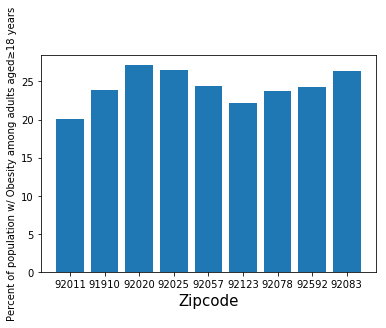

In [38]:
ob = df_behaviors[df_behaviors['Short_Question_Text'] == 'Obesity']
x = np.arange(len(zip_code))
plt.xticks(x, zip_code)
plt.bar(x,ob['Data_Value'])
plt.xlabel('Zipcode',fontsize=15)
plt.ylabel('Percent of population w/ Obesity among adults aged≥18 years')

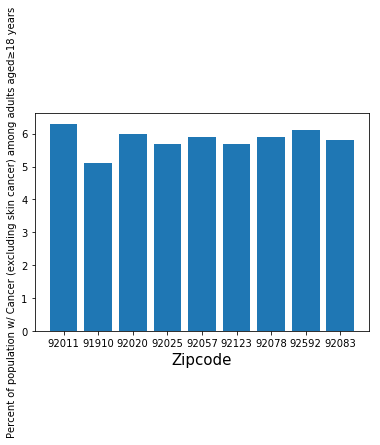

In [39]:
cancer = df_outcomes[df_outcomes['Short_Question_Text'] == 'Cancer (except skin)']
x = np.arange(len(zip_code))
plt.xticks(x, zip_code)
plt.bar(x,cancer['Data_Value'])
plt.xlabel('Zipcode',fontsize=15)
plt.ylabel('Percent of population w/ Cancer (excluding skin cancer) among adults aged≥18 years')

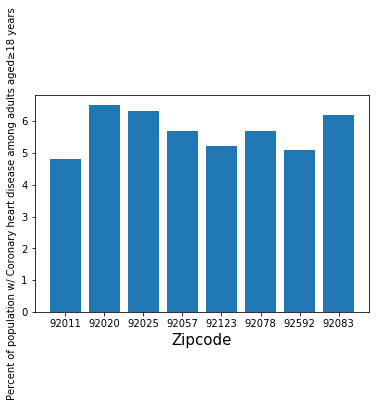

In [40]:
heart = df_outcomes[df_outcomes['Short_Question_Text'] == 'Coronary Heart Disease']
code = heart['ZIP_CODE'].unique()
x = np.arange(len(code))
plt.xticks(x, code)
plt.bar(x,heart['Data_Value'])
plt.xlabel('Zipcode',fontsize=15)
plt.ylabel('Percent of population w/ Coronary heart disease among adults aged≥18 years')

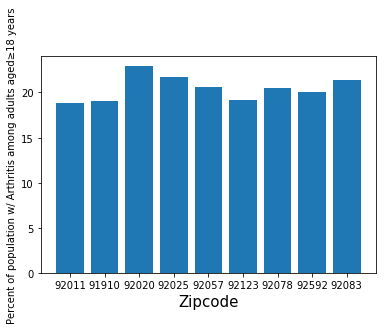

In [41]:
arth = df_outcomes[df_outcomes['Short_Question_Text'] == 'Arthritis']
x = np.arange(len(zip_code))
plt.xticks(x, zip_code)
plt.bar(x,arth['Data_Value'])
plt.xlabel('Zipcode',fontsize=15)
plt.ylabel('Percent of population w/ Arthritis among adults aged≥18 years')

# Data Analysis

We start off by graphing the percent of each zip code’s population with a certain disease against lack of health insurance for that same zip code. Let’s take a look at the graph of each disease and their corresponding Pearson correlation coefficients (this is a measure of the linear correlation between two variables where +/- 1 indicates a strong correlation and 0 indicates no correlation): 

<img src=pearson_r.png>

In [20]:
insurance = df_prevention[df_prevention['Short_Question_Text'] == 'Health Insurance']

For Obesity, we see that there is a value of 0.84, which indicates that there is a very strong correlation between the zip codes with high obesity percentages and also high percentages of  no health insurance. Just looking at the graph, you can also draw the same conclusion. 

Pearson' correlation value: 0.838245497877


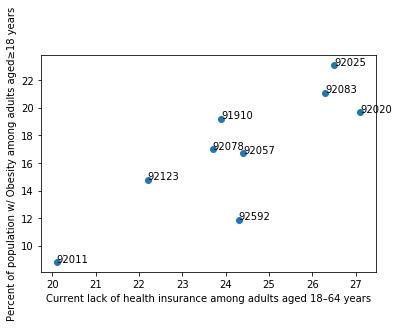

In [45]:
plt.scatter(ob['Data_Value'],insurance['Data_Value'])
p,tailed_p = sp.stats.pearsonr(ob['Data_Value'],insurance['Data_Value'])
length = len(ob['ZIP_CODE'])
name = list(ob['ZIP_CODE'])
x = list(ob['Data_Value'])
y = list(insurance['Data_Value'])
plt.xlabel('Current lack of health insurance among adults aged 18–64 years')
plt.ylabel('Percent of population w/ Obesity among adults aged≥18 years')
for i in range(length):
    plt.annotate(name[i],(x[i],y[i]))
print("Pearson' correlation value:",p)

For Cancer, we see that there is a value of -0.58, which indicates a strong correlation. However, this is not a huge issue because the origins of cancer are still nebulous. Scientists and researchers are still postulating how people get a variety of different cancers so its nice to see a slight correlation regardless.

Pearson' correlation value: -0.577885270194


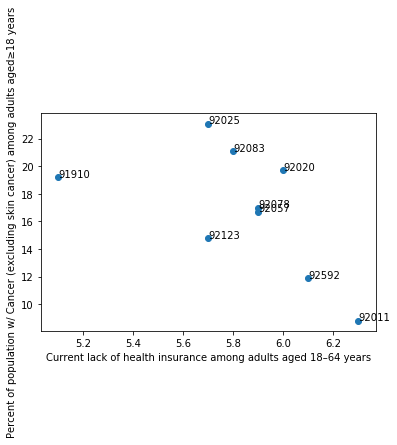

In [46]:
plt.scatter(cancer['Data_Value'],insurance['Data_Value'])
p,tailed_p = sp.stats.pearsonr(cancer['Data_Value'],insurance['Data_Value'])
length = len(cancer['ZIP_CODE'])
name = list(cancer['ZIP_CODE'])
x = list(cancer['Data_Value'])
y = list(insurance['Data_Value'])
plt.xlabel('Current lack of health insurance among adults aged 18–64 years')
plt.ylabel('Percent of population w/ Cancer (excluding skin cancer) among adults aged≥18 years')
for i in range(length):
    plt.annotate(name[i],(x[i],y[i]))
print("Pearson' correlation value:",p)

For Heart Disease, we see that there is a value of 0.66, which indicates a also a strong positive correlation between lack of health insurance and high percentages of heart disease.

Pearson' correlation value: 0.664315908253


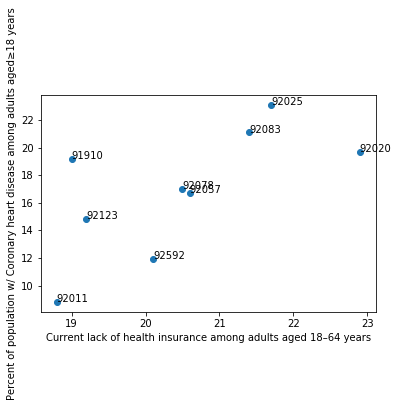

In [47]:
plt.scatter(arth['Data_Value'],insurance['Data_Value'])
p,tailed_p = sp.stats.pearsonr(arth['Data_Value'],insurance['Data_Value'])
length = len(arth['ZIP_CODE'])
name = list(arth['ZIP_CODE'])
x = list(arth['Data_Value'])
y = list(insurance['Data_Value'])
plt.xlabel('Current lack of health insurance among adults aged 18–64 years')
plt.ylabel('Percent of population w/ Coronary heart disease among adults aged≥18 years')
for i in range(length):
    plt.annotate(name[i],(x[i],y[i]))
print("Pearson' correlation value:",p)

For Arthritis, we see that there is a value of 0.94, which indicates a VERY strong positive correlation between lack of health insurance and the prevalence of the disease. The graph also shows a near linear fit, all of which indicates having health insurance reduces the amount of people in the zip code with arthritis. 

0.94216950062936555

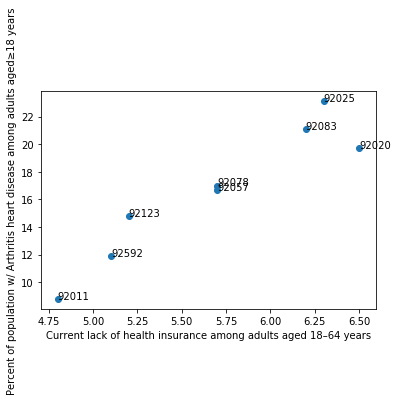

In [48]:
temp = insurance[insurance['ZIP_CODE'] != 91910]
plt.scatter(heart['Data_Value'],temp['Data_Value'])
p,tailed_p = sp.stats.pearsonr(heart['Data_Value'],temp['Data_Value'])
length = len(heart['ZIP_CODE'])
name = list(heart['ZIP_CODE'])
x = list(heart['Data_Value'])
y = list(temp['Data_Value'])
plt.xlabel('Current lack of health insurance among adults aged 18–64 years')
plt.ylabel('Percent of population w/ Arthritis among adults aged≥18 years')
for i in range(length):
    plt.annotate(name[i],(x[i],y[i]))
p

Now health insurance is not the only metric that we want to do a comparison with. We also feel that looking at median household income is important to understanding if wealth has any sort of effect on a zip code’s overall well being. We have shown the regression results for each disease and associated median household income. We will be looking at the r-squared value (which is a statistical representation of closely the data fits a regression line with a value close to 1 being very good and a value close to 0 showing no correlation), the t-value (which shows the size of the difference relative to the variation in your sample data so basically the greater the magnitude of this value the greater the evidence against the null hypothesis), the p-value (closely connected to the t-value, the smaller this value is, the stronger the evidence for the alternative hypothesis), and the f-statistic (which shows us whether or not this grouping of disease and household income is statistically significant, basically if our research findings are meaningful). The explanations of these values was all derived from links provided in the reference section (at the end of this report). Let’s take a look at the regression results of comparing each the percentage of each zip code’s population with a certain disease against the average income in that zip code: 

Looking at Obesity, we see an R-squared value of 0.356, an F-statistic value of 306.6, a t-value of 64.12, and a p-value of 0. Since p-value is 0, this is a strong support for the alternative hypothesis and the rejection of the null hypothesis is further supported by a large t-value. While the r-squared is kind of small, it corresponds to a r value with the magnitude of roughly 0.6, which can be considered strong enough to state the there is a correlation between income and obesity. The scatter plot of this data shows that as median income goes down, the obesity percentages go up, further prompting us to reject the null-hypothesis. 

In [30]:
ob_df = df_merge[df_merge['Short_Question_Text'] == 'Obesity']
outcome_1, predictors_1 = patsy.dmatrices('Data_Value ~ Median_Household_Income', ob_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:             Data_Value   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     306.6
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           5.86e-55
Time:                        23:19:28   Log-Likelihood:                -1517.5
No. Observations:                 556   AIC:                             3039.
Df Residuals:                     554   BIC:                             3048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

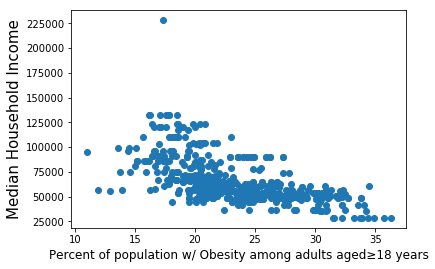

In [57]:
plt.scatter(ob_df['Data_Value'],ob_df['Median_Household_Income'])
plt.xlabel('Percent of population w/ Obesity among adults aged≥18 years',fontsize=12)
plt.ylabel('Median Household Income',fontsize=15)

Looking at Cancer, we see an R-squared value of 0.032, an F-statistic value of 17.88, a t-value of 16.12, and a p-value of 0. These values show a bit weaker correlation as the t-value is quite small compared to that of obesity, the R-squared value and its corresponding absolute r-value (roughly 0.18) are also quite small. However, as discussed in the visualization section, the causes of cancer are still a subject of great debate so these values should not be read into a whole lot. The scatter plot of the cancer percentages further support this weak correlation as we see that you cannot draw a clear conclusion that as income goes down the prevalence of cancer in a zip code goes up.

In [27]:
cancer_df = df_merge[df_merge['Short_Question_Text'] == 'Cancer (except skin)']
outcome_2, predictors_2 = patsy.dmatrices('Data_Value ~ Median_Household_Income', cancer_df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:             Data_Value   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     17.88
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           2.75e-05
Time:                        23:02:11   Log-Likelihood:                -1179.8
No. Observations:                 551   AIC:                             2364.
Df Residuals:                     549   BIC:                             2372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

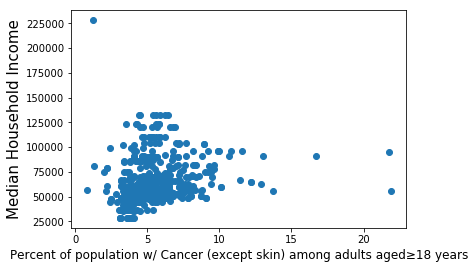

In [58]:
plt.scatter(cancer_df['Data_Value'],cancer_df['Median_Household_Income'])
plt.xlabel('Percent of population w/ Cancer (except skin) among adults aged≥18 years',fontsize=12)
plt.ylabel('Median Household Income',fontsize=15)

Looking at Coronary Heart Disease, we see an R-squared value of 0.062, an F-statistic value of 36.74, a t-value of 29.43, and a p-value of 0. The correlation is a bit stronger than the one we saw with cancer, but not as strong as we would have hoped. The r-squared value and its corresponding absolute r-value (roughly 0.25) indicate that we cannot really say that lower income leads to higher heart disease rates. This is also seen in the plot, which does not indicate a very strong correlation between the two. However, the t-value is quite high as is the f-statistic and the p-value is 0, so there is support for the rejection of the null hypothesis. 

In [32]:
heart_df = df_merge[df_merge['Short_Question_Text'] == 'Coronary Heart Disease']
outcome_3, predictors_3 = patsy.dmatrices('Data_Value ~ Median_Household_Income', heart_df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:             Data_Value   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     36.74
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           2.49e-09
Time:                        23:20:42   Log-Likelihood:                -1093.8
No. Observations:                 561   AIC:                             2192.
Df Residuals:                     559   BIC:                             2200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

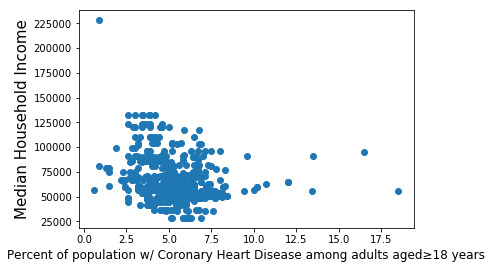

In [59]:
plt.scatter(heart_df['Data_Value'],heart_df['Median_Household_Income'])
plt.xlabel('Percent of population w/ Coronary Heart Disease among adults aged≥18 years',fontsize=12)
plt.ylabel('Median Household Income',fontsize=15)

Looking at Arthritis, we see an R-squared value of 0.019, an F-statistic value of 11.02, a t-value of 35.473, and a p-value of 0.001. This is the weakest correlation of the four disease we have looked at because the r-squared value and its corresponding absolute r value (roughly 0.14) don’t show us a whole lot of correlation between the presence of arthritis in a zip code and the corresponding median income. The plot further supports this, as no clear correlation can be found. 

In [35]:
arth_df = df_merge[df_merge['Short_Question_Text'] == 'Arthritis']
outcome_4, predictors_4 = patsy.dmatrices('Data_Value ~ Median_Household_Income', arth_df)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:             Data_Value   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     11.02
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           0.000961
Time:                        23:21:53   Log-Likelihood:                -1644.9
No. Observations:                 560   AIC:                             3294.
Df Residuals:                     558   BIC:                             3303.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

# Conclusion/Discussion

We first saw that there were strong correlations between percent of population in the major 9 zipcodes in San Diego County between percent of population with one of the 4 main top diseases and percent of the population who lacked health insurance. We decided to look into further confounds by looking at the Median Household income of these zipcodes in San Diego County. After plotting these results it seemed as though the zipcodes with lower percents of the population with these given diseases had lower rates of the population that lacked healthcare had higher Median Household Incomes. We then made 4 different Linear Regression Models and looked at the percent of the population for each given disease and their corresponding incomes. We saw significant t values in all our OLS Models meaning that Median Household Income was statistically significant at predicting percentage of the population affected by the given disease. Lastly we obsereved that our coefficient values for our parameter estimates were very small meaning that for every dollar increase in the zipcode's Median House Income the model predicts the following changes of percent of the population for each of the following diseases:

* Obesity: -0.0001
* Cancer: 1.674e-05
* Coronary Heart Disease: -1.943e-05
* Arthritis: -2.88e-05

# References

Correlation between Socioeconomic Status and Clinical Course in Patients with Cutaneous Leishmaniasis
(https://www.ncbi.nlm.nih.gov/pubmed/25775662)

Relationship between socioeconomic status and the prevalence of cardiovascular disease among retired residents living in a community
(https://www.ncbi.nlm.nih.gov/pubmed/25059355)

How Are Income And Wealth Linked To Health And Longevity?
(http://www.urban.org/sites/default/files/publication/49116/2000178-How-are-Income-and-Wealth-Linked-to-Health-and-Longevity.pdf)

Regression Analysis (https://stats.idre.ucla.edu/stata/output/regression-analysis-2/)

F-statistic (http://www.statisticshowto.com/f-statistic/)

P-value (http://www.investopedia.com/terms/p/p-value.asp)

R-squared value (https://www.linkedin.com/pulse/regression-analysis-how-do-i-interpret-r-squared-assess-gaurhari-dass)

Pearson correlation coefficient (https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
